In [18]:
print("THARANESH P")




THARANESH P


In [19]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow


In [20]:
# Cell purpose: Import required libraries and set seeds for reproducibility.
# Notes:
# - Keep imports in one place so reviewers can see dependencies.
# - Seeds help make training results more repeatable.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/iot_anomaly_colab.ipynb")
print(df.head())


Empty DataFrame
Columns: [{"cells":[{"cell_type":"code", execution_count:null, id:"i3uDiE-9PYFI", metadata:{"colab":{"base_uri":"https://localhost:8080/"}, id:"i3uDiE-9PYFI".1, outputId:"6a8d7816-44cd-4c26-dcc6-f682ed8b5dca"}, outputs:[{"output_type":"stream", name:"stdout", text:["\u001b[?25l     \u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b \u001b0.0/10.9 MB\u001b \u001b?\u001b eta \u001b-:--:--\u001b\r\u001b[2K     \u001b━\u001b\u001b╺\u001b\u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b \u001b0.3/10.9 MB\u001b \u001b9.3 MB/s\u001b eta \u001b0:00:02\u001b\r\u001b[2K     \u001b━━━━━━━━━━━\u001b\u001b╺\u001b\u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b \u001b3.1/10.9 MB\u001b \u001b45.2 MB/s\u001b eta \u001b0:00:01\u001b\r\u001b[2K     \u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b\u001b╸\u001b \u001b10.9/10.9 MB\u001b \u001b187.9 MB/s\u001b eta \u001b0:00:01\u001b\r\u001b[2K     \u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b\u001b╸\u001b \u001b10.9/10.9 MB\u001b \u001b18

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# -------------------------------
# Cell purpose: Generate synthetic time-series data with injected anomalies.
# Notes: Synthetic data provides ground-truth anomalies for evaluation and demonstration.
# -------------------------------

In [5]:
time = np.arange(0, 1000)
signal = np.sin(time/50) + np.random.normal(0, 0.1, 1000)
signal[200:210] += 3  # inject anomaly
signal[700:710] -= 3

df = pd.DataFrame({'time': time, 'value': signal})


In [22]:
# -------------------------------
# Cell purpose: Data cleaning — handle missing values and duplicates.
# Notes: Document how many rows were dropped or imputed and why.
# -------------------------------

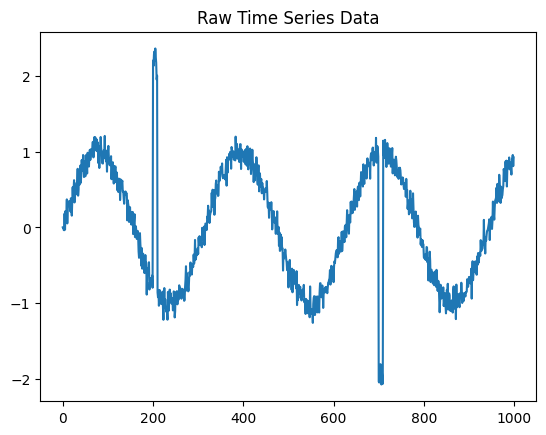

In [6]:
df = df.dropna()
df = df.reset_index(drop=True)
plt.plot(df['time'], df['value'])
plt.title("Raw Time Series Data")
plt.show()


In [23]:
# -------------------------------
# Cell purpose: Data cleaning — handle missing values and duplicates.
# Notes: Document how many rows were dropped or imputed and why.
# -------------------------------

In [7]:
df['rolling_mean'] = df['value'].rolling(window=10).mean()
df['rolling_std'] = df['value'].rolling(window=10).std()
df['diff'] = df['value'].diff()
df = df.dropna()


In [24]:
# -------------------------------
# Cell purpose: Exploratory Data Analysis (EDA) — summary stats and visualizations.
# Notes: Include plots for distribution, rolling mean/std, and any anomalies.
# -------------------------------

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(df[['value', 'rolling_mean', 'rolling_std', 'diff']])


In [25]:
# -------------------------------
# Cell purpose: Train Isolation Forest for unsupervised anomaly detection.
# Notes: 'contamination' sets expected anomaly fraction; tune based on data.
# -------------------------------

In [9]:
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly_iso'] = iso.fit_predict(X)
df['anomaly_iso'] = df['anomaly_iso'].map({1: 0, -1: 1})


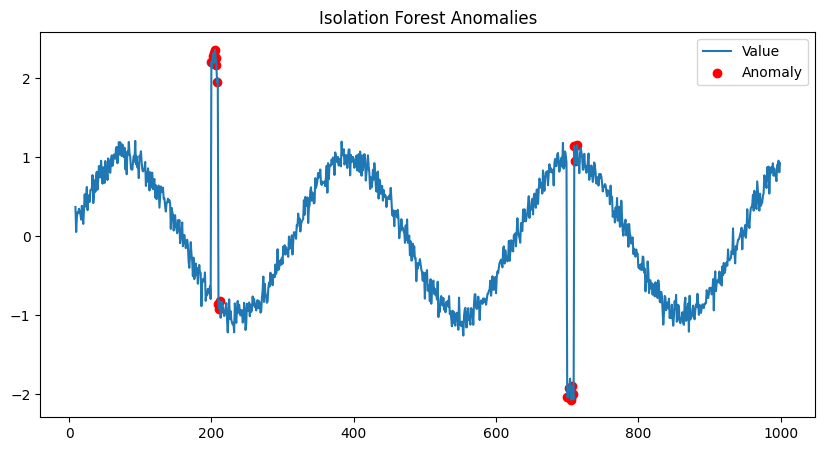

In [10]:
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['value'], label='Value')
plt.scatter(df['time'][df['anomaly_iso']==1], df['value'][df['anomaly_iso']==1], color='red', label='Anomaly')
plt.legend()
plt.title("Isolation Forest Anomalies")
plt.show()


In [27]:
# -------------------------------
# Cell purpose: Define Autoencoder neural network architecture.
# Notes: Use a bottleneck to force compression; tune layers/units.
# -------------------------------

In [11]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X.shape[1],)),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(X.shape[1], activation='linear')
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, X, epochs=50, batch_size=32, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# -------------------------------
# Cell purpose: Compute reconstruction errors and set anomaly threshold.
# Notes: Threshold is heuristic (e.g., 98th percentile); document rationale.
# -------------------------------

In [12]:
reconstructions = model.predict(X)
mse = np.mean(np.power(X - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 98)
df['anomaly_auto'] = (mse > threshold).astype(int)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [29]:
# -------------------------------
# Cell purpose: (General) — perform a step in the pipeline (inspect code).
# Notes: Ensure this cell has a clear caption comment describing its intent.
# -------------------------------

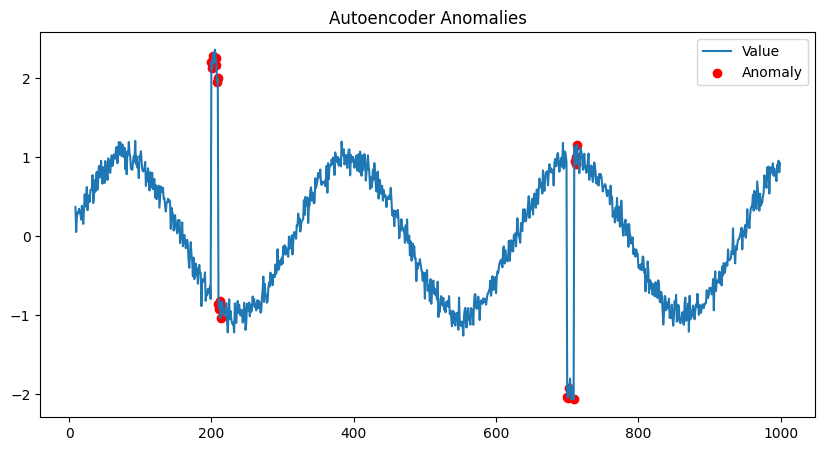

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['value'], label='Value')
plt.scatter(df['time'][df['anomaly_auto']==1], df['value'][df['anomaly_auto']==1], color='red', label='Anomaly')
plt.legend()
plt.title("Autoencoder Anomalies")
plt.show()


In [30]:
# -------------------------------
# Cell purpose: (General) — perform a step in the pipeline (inspect code).
# Notes: Ensure this cell has a clear caption comment describing its intent.
# -------------------------------

In [14]:
print("Isolation Forest anomalies:", df['anomaly_iso'].sum())
print("Autoencoder anomalies:", df['anomaly_auto'].sum())


Isolation Forest anomalies: 20
Autoencoder anomalies: 20


In [31]:
# -------------------------------
# Cell purpose: Save results and models; provide download or copy to Drive in Colab.
# Notes: Ensure Drive is mounted before copying to Drive.
# -------------------------------

In [15]:
df.to_csv("anomaly_results.csv", index=False)


In [16]:
from google.colab import files
files.download("anomaly_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>